Total time for all simulations: 3.58 seconds


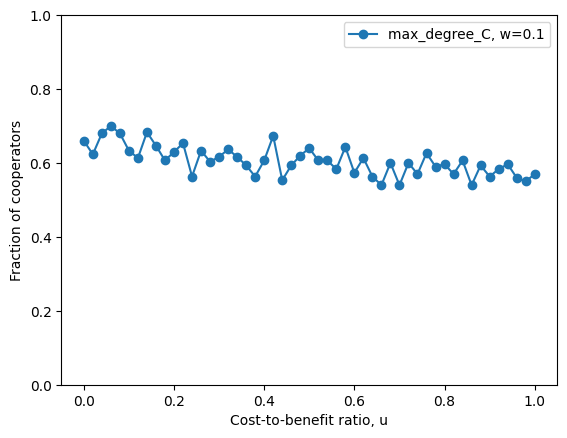

In [3]:
import networkx as nx
import numpy as np
import random
import time
import matplotlib.pyplot as plt

def initialize_network(N, m, initial_defector_ratio):
    """
    Creates a Barabási–Albert (BA) graph and randomly assigns states to nodes.
    The BA algorithm:
      1. Starts with a small complete graph (handled internally by nx.barabasi_albert_graph).
      2. Adds new nodes one at a time, each connecting to m existing nodes with a probability proportional to the node's degree.
    Parameters:
      N - Total number of nodes.
      m - Number of edges each new node attaches to (must be less than N).
      initial_defector_ratio - Initial fraction of defectors ('D').
    Returns:
      A BA graph with node state information stored in the attribute 'state'.
    """
    G = nx.barabasi_albert_graph(N, m)
    num_defectors = int(N * initial_defector_ratio)
    states = ['D'] * num_defectors + ['C'] * (N - num_defectors)
    random.shuffle(states)
    # Assign each node a state ('C' for cooperators, 'D' for defectors)
    for node, state in zip(G.nodes(), states):
        G.nodes[node]['state'] = state
    return G

def update_strategy(G, alpha, u, discordant_edges):
    """
    Selects a discordant edge (an edge connecting nodes with different states) at random.
    Calculates the payoffs for the cooperating and defecting nodes:
      - The cooperator's payoff is the count of cooperating neighbors.
      - The defector's payoff is (1+u) times the number of cooperating neighbors plus u times the number of defecting neighbors.
    If the payoff difference is greater than 2, the transition probability is set to 0.
    Then, based on the calculated probability, updates the state of one of the nodes.
    Finally, updates the set of discordant edges associated with the changed node.
    """
    if discordant_edges:
        # Convert discordant_edges set to a tuple and select a random edge
        edge = random.choice(tuple(discordant_edges))
        # Identify which node in the edge is the cooperator; label the edge as (C-node, D-node)
        c_node, d_node = edge if G.nodes[edge[0]]['state'] == 'C' else (edge[1], edge[0])
        # Calculate payoffs for both nodes
        payoff1 = sum(1 for n in G.neighbors(c_node) if G.nodes[n]['state'] == 'C')
        payoff2 = sum((1 + u) if G.nodes[n]['state'] == 'C' else u for n in G.neighbors(d_node))
        # If the payoff difference is greater than 2, set the transition probability to 0.
        probability_1_to_2 = 1 / (1 + np.exp(alpha * (payoff1 - payoff2))) if (payoff1 - payoff2) <= 2 else 0
        # Update the state based on the computed probability.
        if random.random() < probability_1_to_2:
            G.nodes[c_node]['state'] = 'D'
            changed_node = c_node
        else:
            G.nodes[d_node]['state'] = 'C'
            changed_node = d_node
        discordant_edges.discard(edge)
        # Update the discordant edges for the changed node and its neighbors.
        for neighbor in G.neighbors(changed_node):
            potential_edge = tuple(sorted([changed_node, neighbor]))
            if G.nodes[changed_node]['state'] != G.nodes[neighbor]['state']:
                discordant_edges.add(potential_edge)
            else:
                discordant_edges.discard(potential_edge)
    return discordant_edges

def rewire(G, discordant_edges, strategy_type, p, threshold):
    """
    Performs a rewiring operation:
      - Randomly selects a discordant edge and removes it.
      - Chooses a new connection for the cooperator node (c_node) based on the specified strategy.
    Strategies include:
      'max_degree_C': Select the cooperator with the maximum degree.
      'min_degree_C': Select the cooperator with the minimum degree.
      'nearest_C': Select the closest cooperator node (based on shortest path length).
      'farthest_C': Select the farthest cooperator node (based on shortest path length).
      'probabilistic': With probability p, select a cooperator; otherwise, select a random node.
      'random': Select a random node from the set of potential nodes.
    After adding the new edge, updates the set of discordant edges.
    """
    if discordant_edges:
        edge = random.choice(tuple(discordant_edges))
        c_node, d_node = edge if G.nodes[edge[0]]['state'] == 'C' else (edge[1], edge[0])
        G.remove_edge(*edge)
        discordant_edges.discard(edge)
        # Get the set of nodes not currently connected to c_node (excluding itself)
        neighbors_set = set(G.neighbors(c_node))
        potential_nodes = list(set(G.nodes()) - neighbors_set - {c_node})
        new_node = None

        # For the 'hybrid' strategy, choose a sub-strategy based on the overall cooperation fraction
        if strategy_type == 'hybrid':
            coop_fraction = calculate_cooperation_fraction(G)
            if coop_fraction < threshold:
                strategy_type = 'max_degree_C'
            else:
                strategy_type = 'min_degree_C'

        if strategy_type == 'max_degree_C':
            max_degree = -1
            for node in potential_nodes:
                if G.nodes[node]['state'] == 'C' and G.degree[node] > max_degree:
                    max_degree = G.degree[node]
                    new_node = node
        elif strategy_type == 'min_degree_C':
            min_degree = float('inf')
            for node in potential_nodes:
                if G.nodes[node]['state'] == 'C' and G.degree[node] < min_degree:
                    min_degree = G.degree[node]
                    new_node = node
        elif strategy_type == 'probabilistic':
            if random.random() < p:
                cooperators = [node for node in potential_nodes if G.nodes[node]['state'] == 'C']
                new_node = random.choice(cooperators) if cooperators else random.choice(potential_nodes)
            else:
                new_node = random.choice(potential_nodes)
        elif strategy_type == 'random':
            if potential_nodes:
                new_node = random.choice(potential_nodes)

        # If no suitable new node was found, select one randomly from potential_nodes.
        if new_node is None and potential_nodes:
            new_node = random.choice(potential_nodes)
        if new_node:
            G.add_edge(c_node, new_node)
            # Update discordant edges for the new connections of c_node.
            for neighbor in G.neighbors(c_node):
                potential_edge = tuple(sorted([c_node, neighbor]))
                if G.nodes[c_node]['state'] != G.nodes[neighbor]['state']:
                    discordant_edges.add(potential_edge)
                else:
                    discordant_edges.discard(potential_edge)
    return discordant_edges

def simulate(G, alpha, u, w, max_times, strategy_type, p, threshold):
    """
    Simulates the evolution of the network until either the maximum number of iterations is reached
    or there are no discordant edges left (i.e., all edges connect nodes with the same state).
    In each iteration, either the strategy is updated or an edge is rewired based on the probability weight w.
    """
    iteration = 0
    # Initialize the set of discordant edges (stored as sorted tuples to represent undirected edges)
    discordant_edges = set(tuple(sorted((i, j))) for i, j in G.edges() if G.nodes[i]['state'] != G.nodes[j]['state'])
    while iteration < max_times and discordant_edges:
        if random.random() < w:
            discordant_edges = update_strategy(G, alpha, u, discordant_edges)
        else:
            discordant_edges = rewire(G, discordant_edges, strategy_type, p, threshold)
        iteration += 1
    return G

def calculate_cooperation_fraction(G):
    """
    Calculates the fraction of nodes that are cooperators ('C') in the network.
    """
    cooperators = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'C')
    return cooperators / G.number_of_nodes()

def simulate_and_average_cooperation(N, m, initial_defector_ratio, alpha, u, w, simulations, max_times, strategy_type, p, threshold):
    """
    Runs multiple simulations and returns the average fraction of cooperators over all simulations.
    """
    total_cooperation = 0
    for _ in range(simulations):
        G = initialize_network(N, m, initial_defector_ratio)
        simulate(G, alpha, u, w, max_times, strategy_type, p, threshold)
        total_cooperation += calculate_cooperation_fraction(G)
    return total_cooperation / simulations

def run_simulation_for_different_w(w_values, N, m, initial_defector_ratio, alpha, u_values, simulations, max_times, strategy_types, p, threshold):
    """
    Runs the simulation for different values of w (the probability weight for strategy update versus rewiring)
    and for various values of u (cost-to-benefit ratio) for each specified rewiring strategy.
    Returns a dictionary with the simulation results.
    """
    results = {}
    start_time = time.time()
    for strategy_type in strategy_types:
        for w in w_values:
            cooperation_fractions = []
            for u in u_values:
                avg_cooperation = simulate_and_average_cooperation(
                    N, m, initial_defector_ratio, alpha, u, w, simulations, max_times, strategy_type, p, threshold
                )
                cooperation_fractions.append(avg_cooperation)
            results[(strategy_type, w)] = cooperation_fractions
    print(f"Total time for all simulations: {time.time() - start_time:.2f} seconds")
    return results

def plot_multiple_cooperation_vs_u(u_values, results):
    """
    Plots the relationship between u (cost-to-benefit ratio) and the fraction of cooperators for each combination
    of rewiring strategy and probability weight w.
    """
    for (strategy_type, w), cooperation_fractions in results.items():
        plt.plot(u_values, cooperation_fractions, marker='o', label=f'{strategy_type}, w={w}')
    plt.xlabel('Cost-to-benefit ratio, u')
    plt.ylabel('Fraction of cooperators')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

# -------------------------------
# Simulation example parameters (using BA model for the initial network)
N = 100                  # Total number of nodes
m = 5                     # Each new node connects to m existing nodes in the BA model
initial_defector_ratio = 0.5
alpha = 30
u_values = np.linspace(0, 1, 51)  # Array of u values ranging from 0 to 1
w_values = [0.1]           # Probability weight for strategy update versus rewiring
simulations = 3
max_times = 2 * 10**12
strategy_types = ['max_degree_C']
p = 1
threshold = 0.5

# Execute simulations and plot results
results = run_simulation_for_different_w(w_values, N, m, initial_defector_ratio, alpha, u_values, simulations, max_times, strategy_types, p, threshold)
plot_multiple_cooperation_vs_u(u_values, results)
